# Libraries

In [1]:
%matplotlib notebook
# %matplotlib inline 
# %matplotlib qt
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import glob

# Functions

In [36]:
# функции демонстрации изображения
def show_image(img, name):
    plt.figure(name)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

# загрузка всех изображений по пути
def load_images(path):
    filenames = [img for img in glob.glob(path)] 
    filenames.sort()

    assert len(filenames) >= 1
    
    print(filenames)
    
    images = []
    for img_filename in filenames:
        n = cv2.imread(img_filename)
        n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        n = n.astype('float')
        images.append(n)

    return images

    print("found " + str(len(images)) + " images")

    print('высота: ' + str(images[0].shape[0]))
    print('ширина: ' + str(images[0].shape[1]))
    
# фильтрация изображения линейным фильтром
def filter_image(image, vetrical_alignment, horizontal_alignment):
    filtered_image = image.copy().astype('double')

    kernel = np.ones((vetrical_alignment,horizontal_alignment), np.float32) / (vetrical_alignment * horizontal_alignment)
    filtered_image = cv2.filter2D(filtered_image,-1,kernel)
    
    return filtered_image

# фильтрация пиков в изображении медианным фильтром
def filter_peaks_slow(image, kernel_size = 1):
    assert kernel_size >= 1
    
    result_image = np.copy(image)
    for x in range(kernel_size, image.shape[0] - kernel_size):
        for y in range(kernel_size, image.shape[1] - kernel_size):
            values = image[x - kernel_size : x + kernel_size, y - kernel_size : y + kernel_size].copy()
            values[kernel_size, kernel_size] = np.nan
            _max = np.nanmax(values)
            _min = np.nanmin(values)
            if result_image[x, y] > _max or result_image[x, y] < _min:
                # print(x, y)
                result_image[x, y] = np.nanmean(values)
    return result_image




# получение двух границ на изображении в зависимости от положения засветки
# axis = vertical border? 1: 0
def get_borders(image_gap, axis=1):
    img_diff = np.diff(image_gap, axis=axis)

    l_border_val = np.max(img_diff, axis=axis)
    r_border_val = np.min(img_diff, axis=axis)

    _l_border_ind = np.argmax(img_diff, axis=axis)
    _r_border_ind = np.argmin(img_diff, axis=axis)
    
    return _l_border_ind, _r_border_ind


def find_closest_by_brightness(line, value):
    best_fit_index = 0
    temp_delta = np.max(line)
    for ind in range(len(line)):
        cur_delta = abs(line[ind] - value)
        if cur_delta < temp_delta:
            best_fit_index = ind
            temp_delta = cur_delta
    return best_fit_index

def get_borders_a_b(image_gap, slice_size=32):
    half_width = int(image_gap.shape[1] / 2)
    
    image_1st_border = image_gap[:, :half_width]
    image_2nd_border = image_gap[:, half_width:]
    
    a_1st = np.mean(image_1st_border[:, 0:slice_size], axis=1)
    b_1st = np.mean(image_1st_border[:, -slice_size:], axis=1)
    
    a_2nd = np.mean(image_2nd_border[:, 0:slice_size], axis=1)
    b_2nd = np.mean(image_2nd_border[:, -slice_size:], axis=1)
    
    
    border_1st_ind = np.zeros(image_1st_border.shape[0])
    border_2nd_ind = np.zeros(image_2nd_border.shape[0])
    
    for i in range(image_1st_border.shape[0]):
        border_1st_ind[i] = find_closest_by_brightness(image_1st_border[i, :], ((a_1st[i] + b_1st[i]) / 2))
    
    for i in range(image_2nd_border.shape[0]):
        border_2nd_ind[i] = find_closest_by_brightness(image_2nd_border[i, :], ((a_2nd[i] + b_2nd[i]) / 2)) + half_width
    
    
    
    return border_1st_ind, border_2nd_ind

# отрисовка списка границ на изображение
def draw_borders(image, borders):
    _image_with_borders = image.copy().astype('double')
    
    assert type(borders) == list
    
    for border in borders:
        for x in range(len(border)):
            cv2.circle(_image_with_borders, (int(border[x]), x), 0, (255, 0, 0) )
    return _image_with_borders

def draw_borders_color(image, borders):
    _image_with_borders = image.copy().astype('uint8')
    n = cv2.cvtColor(_image_with_borders, cv2.COLOR_GRAY2RGB)
    assert type(borders) == list
    border1 = borders[0]
    for x in range(len(border1)):
        cv2.circle(_image_with_borders, (int(border1[x]), x), 0, (255, 255, 0) )
        
    border2 = borders[1]
    for x in range(len(border2)):
        cv2.circle(_image_with_borders, (int(border2[x]), x), 0, (0, 255, 0) )
    return _image_with_borders

# получение изображения границы с некоторым запасом
def get_border_image(image, border, additional_size=32):
    slice_size = int(border.shape[0] / 10)

    x_down = min( int(np.mean(border[0:slice_size])), int(np.mean(border[-slice_size:]))) - additional_size
    x_up   = max( int(np.mean(border[0:slice_size])), int(np.mean(border[-slice_size:]))) + additional_size
    
    border_image = np.copy(image[:, x_down : x_up])
    return border_image

# предсказать как проходит линия от точки A до точки B
def predict_line(A, B):
    x = [A[0], B[0]]
    y = [A[1], B[1]]

    coefficients = np.polyfit(x, y, 1)

    
    polynomial = np.poly1d(coefficients)
    x_axis = np.arange(A[0], B[0]) # np.linspace(A[0], B[0])
    y_axis = coefficients[0] * x_axis + coefficients[1]
    return x_axis, y_axis

# получение расширенного изображения по горизонтальной оси
def expand_image(image, expansion_coefficient=10):
    empty_image = np.zeros((image.shape[0], image.shape[1]*expansion_coefficient))
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1] - 1):
            for i in range(expansion_coefficient):
                delta = ((image[y, x + 1] - image[y, x]) / expansion_coefficient)
                empty_image[y, expansion_coefficient * x + i] = image[y, x] + i * delta
    for y in range(image.shape[0]):
        x = image.shape[1] - 1
        for i in range(expansion_coefficient):
            empty_image[y, expansion_coefficient * x + i] = image[y, x]
    
    result_image = empty_image
    return result_image;

## Load images

In [3]:
# Photo/27_01_2020_Process/*.bmp
# Photo/200122__2gaps_Binning2/*.bmp
original_images = load_images("Photo/27_01_2020_Process/*.bmp")

assert len(original_images) > 0

original_image = original_images[0].copy()

image_left  = original_image[:, :(int(original_image.shape[1] / 2))]
image_right = original_image[:,  (int(original_image.shape[1] / 2)):]

assert image_left.shape[1] == original_image.shape[1] / 2

show_image(original_image, "original image")

['Photo/27_01_2020_Process\\NoAuto_Gain15db_1to10000sec_19-00.bmp', 'Photo/27_01_2020_Process\\NoAuto_Gain9db_1to10000sec_19-04.bmp']


<IPython.core.display.Javascript object>

## Filter image

### delete peaks

In [4]:
image_left_without_peaks = filter_peaks_slow(image_left, 3)
image_left_without_peaks = filter_peaks_slow(image_left_without_peaks, 3)

In [5]:
# f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
# ax1.imshow(image_left, cmap='gray', vmin=0, vmax=255)
# ax2.imshow(image_left_without_peaks, cmap='gray', vmin=0, vmax=255)

## Linear filter

In [6]:
# filtered_image = filter_image(original_image, vetrical_alignment = 32, horizontal_alignment = 32)
filtered_image_left =  filter_image(image_left, vetrical_alignment = 10, horizontal_alignment = 10)
filtered_image_right = filter_image(image_right, vetrical_alignment = 10, horizontal_alignment = 10)

assert filtered_image_left.shape[1] == original_image.shape[1] / 2

filtered_image_left_without_peaks = filter_image(image_left_without_peaks, vetrical_alignment = 10, horizontal_alignment = 10)

# Show result of filtering

In [7]:
# f, axs = plt.subplots(2, 2, sharex=True, sharey=True)
# axs[0, 0].imshow(image_left, cmap='gray', vmin=0, vmax=255)
# axs[0, 1].imshow(image_left_without_peaks, cmap='gray', vmin=0, vmax=255)
# axs[1, 0].imshow(filtered_image_left, cmap='gray', vmin=0, vmax=255)
# axs[1, 1].imshow(filtered_image_left_without_peaks, cmap='gray', vmin=0, vmax=255)

## Borders  old algorithm

In [8]:
left_l_border_ind, left_r_border_ind = get_borders(filtered_image_left, 1)
right_l_border_ind, right_r_border_ind = get_borders(filtered_image_right, 1)

left_border_list = []
left_border_list.append(left_l_border_ind)
left_border_list.append(left_r_border_ind)

right_border_list = []
right_border_list.append(right_l_border_ind)
right_border_list.append(right_r_border_ind)


image_left_with_borders = draw_borders(image_left, left_border_list)
image_right_with_borders = draw_borders(image_right, right_border_list)

assert image_left_with_borders.shape[1] == original_image.shape[1] / 2

full_image_with_borders = np.hstack((image_left_with_borders, image_right_with_borders))

show_image(full_image_with_borders, "Image with borders")

<IPython.core.display.Javascript object>

In [9]:
Additional_size = 32

## Getting image of only borders

In [10]:
image_of_left_1st_border = get_border_image(original_image, left_l_border_ind, additional_size=Additional_size)
image_of_left_2nd_border = get_border_image(original_image, left_r_border_ind, additional_size=Additional_size)

image_of_right_1st_border = get_border_image(original_image, right_l_border_ind, additional_size=Additional_size)
image_of_right_2nd_border = get_border_image(original_image, right_r_border_ind, additional_size=Additional_size)

image_of_left_borders = np.hstack((image_of_left_1st_border, image_of_left_2nd_border))
image_of_right_borders = np.hstack((image_of_right_1st_border, image_of_right_2nd_border))

show_image(image_of_left_borders, "image of left borders")

<IPython.core.display.Javascript object>

## filter images of borders

In [11]:
image_of_left_borders_without_peaks  = filter_peaks_slow(image_of_left_borders, 3)
image_of_right_borders_without_peaks = filter_peaks_slow(image_of_right_borders, 3)

image_of_left_borders_filtered  = filter_image(image_of_left_borders_without_peaks , 5, 3)
image_of_right_borders_filtered = filter_image(image_of_right_borders_without_peaks, 5, 3)

# show_image(image_of_left_borders_filtered, "def name")

## expand image

In [12]:
expanded_image_left_border  = expand_image(image_of_left_borders_filtered,  expansion_coefficient=10)
expanded_image_right_border = expand_image(image_of_right_borders_filtered, expansion_coefficient=10)

## show results

In [24]:
# f, axs = plt.subplots(1, 2, sharey=True)#, sharex=True)
# axs[0].imshow(image_of_left_borders_filtered, cmap='gray', vmin=0, vmax=255)
# axs[1].imshow(expanded_image_left_border, cmap='gray', vmin=0, vmax=255)

## Getting borders on expanded image

<IPython.core.display.Javascript object>


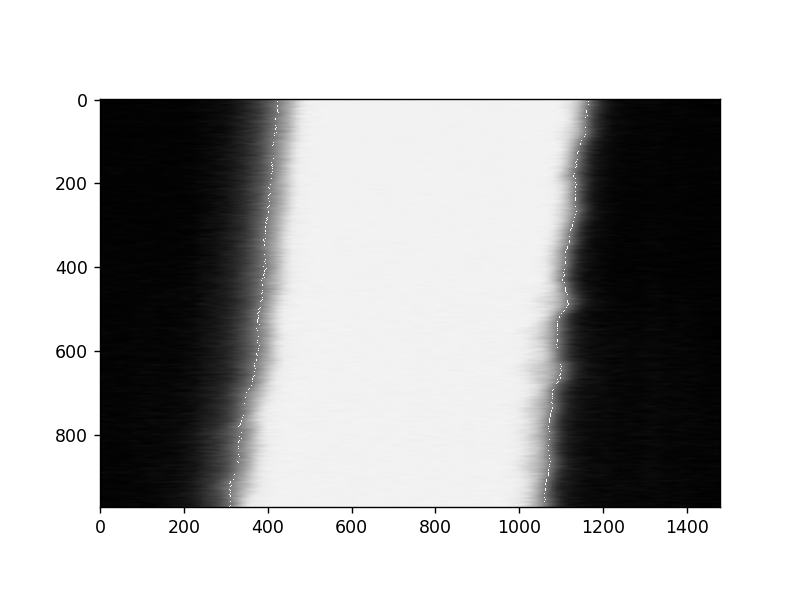

In [40]:
left_l_border_ind_a_b,  left_r_border_ind_a_b  = get_borders_a_b(expanded_image_left_border)
right_l_border_ind_a_b, right_r_border_ind_a_b = get_borders_a_b(expanded_image_right_border)

left_border_list_a_b = []
left_border_list_a_b.append(left_l_border_ind_a_b)
left_border_list_a_b.append(left_r_border_ind_a_b)

right_border_list_a_b = []
right_border_list_a_b.append(right_l_border_ind_a_b)
right_border_list_a_b.append(right_r_border_ind_a_b)

image_left_with_borders_a_b  = draw_borders(expanded_image_left_border, left_border_list_a_b)
image_right_with_borders_a_b = draw_borders(expanded_image_right_border, right_border_list_a_b)

full_image_with_borders = np.hstack((image_left_with_borders_a_b, image_right_with_borders))

show_image(image_left_with_borders_a_b, "Image with borders A B")

In [55]:
def create_simple_approximation(border, slice_size):
    A = [0 + slice_size / 2, np.mean(border[:slice_size])]
    B = [border.shape[0] - slice_size / 2, np.mean(border[-slice_size:])]
    x_axis, y_axis = predict_line(A, B)
    return x_axis, y_axis

def create_complex_approximation(border, slice_size, slice_count):
    x_axis = []
    y_axis = []
    for i in range (slice_count - 1):
        x = slice_size * i
        next_x = x + slice_size
        _A = [x       + slice_size / 2, np.mean(border[x      : (x      + slice_size)])]
        _B = [next_x  + slice_size / 2, np.mean(border[next_x : (next_x + slice_size)])]

        x_axis_cur, y_axis_cur = predict_line(_A, _B)

        x_axis = np.hstack((x_axis, x_axis_cur))
        y_axis = np.hstack((y_axis, y_axis_cur))
    return x_axis, y_axis

<IPython.core.display.Javascript object>


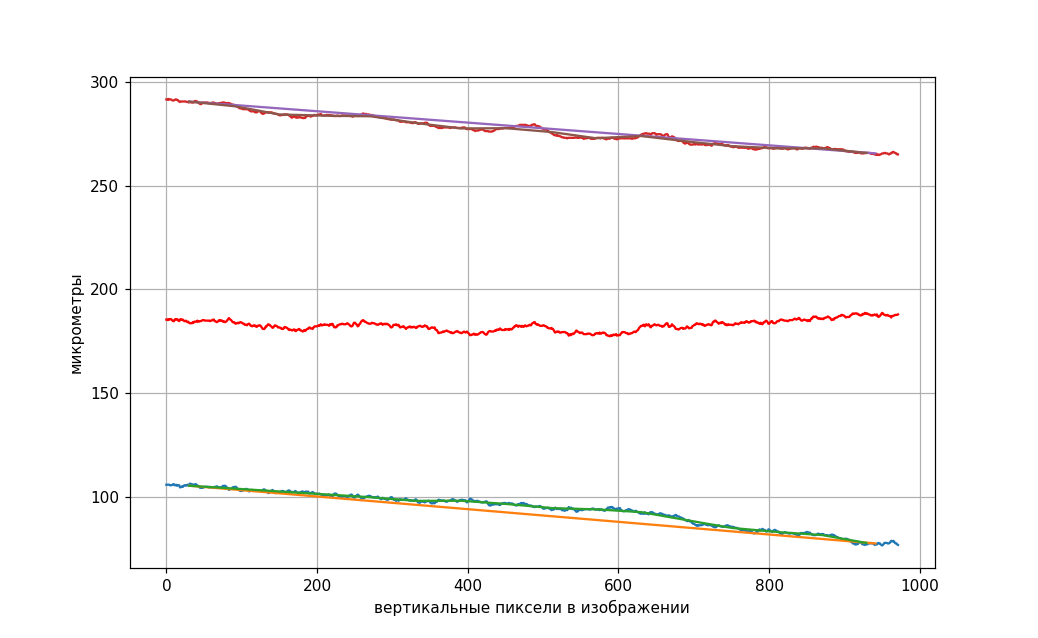

Дельта между границами (красный график):
максимальное значение 188.75 мкм
минимальное значение 177.5 мкм
разница 11.25 мкм


In [91]:
cur_border_razor  = left_l_border_ind_a_b # 
cur_border_tablet = left_r_border_ind_a_b 

slice_count = 16
slice_size = int(cur_border_razor.shape[0] / slice_count)

tablet_x_axis_simple,  tablet_y_axis_simple = create_simple_approximation(cur_border_tablet, slice_size)
tablet_x_axis_complex, tablet_y_axis_complex = create_complex_approximation(cur_border_tablet, slice_size, slice_count)

razor_x_axis_simple,  razor_y_axis_simple = create_simple_approximation(cur_border_razor, slice_size)
razor_x_axis_complex, razor_y_axis_complex = create_complex_approximation(cur_border_razor, slice_size, slice_count)


factor = 1 / 10 * 2.5   # коэффициент перевода в микрометры 
    
plt.figure("Графики границ")
plt.plot(cur_border_razor * factor,label='razor data') # linestyle='--', marker='o', markersize=1, 
plt.plot(razor_x_axis_simple,  razor_y_axis_simple  * factor, label='razor Simple line')
plt.plot(razor_x_axis_complex, razor_y_axis_complex * factor, label='razor Smart line')

plt.plot(cur_border_tablet * factor, label='tablet data')
plt.plot(tablet_x_axis_simple,  tablet_y_axis_simple  * factor, label='tablet Simple line')
plt.plot(tablet_x_axis_complex, tablet_y_axis_complex * factor, label='tablet Smart line')

plt.plot((cur_border_tablet - cur_border_razor) * factor, '-r', label='delta data')

plt.ylabel('микрометры')
plt.xlabel('вертикальные пиксели в изображении')

# plt.legend();
plt.grid('on')
plt.savefig('result.png', dpi=800)

print('Дельта между границами (красный график):')
_max = np.max((cur_border_tablet - cur_border_razor) * factor)
_min = np.min((cur_border_tablet - cur_border_razor) * factor)
# print(str()) + 'мкм') 
print('максимальное значение ' + str(_max) + ' мкм')
print('минимальное значение ' + str(_min) + ' мкм')
print('разница ' + str(_max - _min) + ' мкм')